<a href="https://colab.research.google.com/github/masonmill/rec-systems/blob/main/movie_recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
! curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3859k      0 --:--:-- --:--:-- --:--:-- 3851k


In [2]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [3]:
# import the dataset
import pandas as pd
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [4]:
print('The dimensions of movies dataframe are:', movies_df.shape,'\nThe dimensions of ratings dataframe are:', ratings_df.shape)
print('\n')

The dimensions of movies dataframe are: (9742, 3) 
The dimensions of ratings dataframe are: (100836, 4)




In [5]:
# movies_df
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# ratings_df
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Movie ID to movie name mapping
movie_names = movies_df.set_index('movieId')['title'].to_dict()
n_users = len(ratings_df.userId.unique())
n_items = len(ratings_df.movieId.unique())
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements')
print('\n')
print("Number of ratings:", len(ratings_df))
print(len(ratings_df) / (n_users*n_items) * 100, '% of the matrix is filled')
print("Our ratings matrix is very sparse")
print("Using matrix factorization, we can realize the rating matrix implicitly")
print('\n')

Number of unique users: 610
Number of unique movies: 9724
The full rating matrix will have: 5931640 elements


Number of ratings: 100836
1.6999683055613624 % of the matrix is filled
Our ratings matrix is very sparse
Using matrix factorization, we can realize the rating matrix implicitly




In [8]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # lookup table for the input
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # lookup table for the input
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)

    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [9]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Not best practice, but the data is already loaded in memory
class Loader(Dataset):
    def __init__(self):
        self.ratings = ratings_df.copy()

        # Extract all user IDs and movie IDs
        users = ratings_df.userId.unique()
        movies = ratings_df.movieId.unique()

        #--- Producing new continuous IDs for users and movies ---

        # Unique values : index
        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}

        # Obtained continuous ID for users and movies
        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}

        # return the id from the indexed values as noted in the lambda function down below
        self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
        self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])


        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

In [10]:
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)
print('\n')

model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# GPU enable if you have a GPU
if cuda:
    model = model.cuda()

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train data
train_set = Loader()
train_loader = DataLoader(train_set, 128, shuffle=True)

Is running on GPU: True


MatrixFactorization(
  (user_factors): Embedding(610, 8)
  (item_factors): Embedding(9724, 8)
)
user_factors.weight tensor([[0.0446, 0.0398, 0.0458,  ..., 0.0239, 0.0322, 0.0067],
        [0.0340, 0.0423, 0.0279,  ..., 0.0016, 0.0186, 0.0002],
        [0.0290, 0.0344, 0.0019,  ..., 0.0389, 0.0474, 0.0045],
        ...,
        [0.0312, 0.0230, 0.0055,  ..., 0.0331, 0.0145, 0.0262],
        [0.0116, 0.0025, 0.0167,  ..., 0.0349, 0.0064, 0.0284],
        [0.0080, 0.0191, 0.0281,  ..., 0.0261, 0.0383, 0.0384]])
item_factors.weight tensor([[0.0014, 0.0163, 0.0398,  ..., 0.0028, 0.0317, 0.0083],
        [0.0234, 0.0198, 0.0271,  ..., 0.0085, 0.0117, 0.0285],
        [0.0260, 0.0213, 0.0014,  ..., 0.0128, 0.0300, 0.0312],
        ...,
        [0.0027, 0.0139, 0.0116,  ..., 0.0404, 0.0057, 0.0022],
        [0.0490, 0.0185, 0.0119,  ..., 0.0070, 0.0051, 0.0380],
        [0.0006, 0.0157, 0.0408,  ..., 0.0049, 0.0393, 0.0335]])


In [11]:

for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
         if cuda:
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    print("iter #{}".format(it), "Loss:", sum(losses) / len(losses))

print('\n')

<ipython-input-11-6ec2ea80bebd>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

iter #0 Loss: 11.076145976328002
iter #1 Loss: 4.746014322726254
iter #2 Loss: 2.4741185454245147
iter #3 Loss: 1.720372638272755
iter #4 Loss: 1.3453067569865793
iter #5 Loss: 1.1281923360479664
iter #6 Loss: 0.9912866814638758
iter #7 Loss: 0.9002704115083375
iter #8 Loss: 0.8372566960941111
iter #9 Loss: 0.7921692844347905
iter #10 Loss: 0.7595565906787282
iter #11 Loss: 0.7347943966612598
iter #12 Loss: 0.7162701995844768
iter #13 Loss: 0.7016932848595121
iter #14 Loss: 0.6904111198211079
iter #15 Loss: 0.6815140180781408
iter #16 Loss: 0.674955306886719
iter #17 Loss: 0.6697026622023075
iter #18 Loss: 0.6657814437211468
iter #19 Loss: 0.6630115212522788
iter #20 Loss: 0.660814488751029
iter #21 Loss: 0.6589285211665982
iter #22 Loss: 0.6576895582570037
iter #23 Loss: 0.6567830487253702
iter #24 Loss: 0.6557384795192535
iter #25 Loss: 0.6549988598160937
iter #26 Loss: 0.6546155221495532
iter #27 Loss: 0.6534536066394167
iter #28 Loss: 0.6528577827635755
iter #29 Loss: 0.65121769360

In [12]:
# By training the model, we will have tuned latent factors for movies and users
c = 0
uw = 0
iw = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data

user_factors.weight tensor([[ 1.5017,  1.7049,  1.4286,  ...,  1.1406,  0.7918,  0.6323],
        [ 1.4205,  0.6305,  1.1625,  ...,  0.6348,  1.2189,  1.0422],
        [ 0.4928,  1.3284, -1.6471,  ...,  1.8414,  0.2835,  0.9089],
        ...,
        [ 0.8242,  0.3781,  0.3703,  ...,  2.2307, -0.0379,  2.2486],
        [ 0.5391,  0.7047,  0.9437,  ...,  0.9848,  1.2299,  1.5324],
        [ 0.9526,  1.0925,  1.2088,  ...,  0.0118,  1.3258,  1.5788]],
       device='cuda:0')
item_factors.weight tensor([[0.5574, 0.4135, 0.3953,  ..., 0.1464, 0.7356, 0.7033],
        [0.0239, 0.9129, 0.1492,  ..., 0.1443, 0.6056, 0.5431],
        [0.4819, 0.2788, 0.1727,  ..., 0.4550, 0.5977, 0.7073],
        ...,
        [0.3289, 0.3389, 0.3359,  ..., 0.2515, 0.3306, 0.3262],
        [0.4252, 0.3946, 0.3874,  ..., 0.3249, 0.3799, 0.4139],
        [0.3885, 0.4031, 0.4286,  ..., 0.3137, 0.4270, 0.4224]],
       device='cuda:0')


In [13]:
trained_movie_embeddings = model.item_factors.weight.data.cpu().numpy()

In [14]:
len(trained_movie_embeddings) # unique movie factor weights

9724

In [15]:
from sklearn.cluster import KMeans
# Fit the clusters based on the movie weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_movie_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
'''It can be seen here that the movies that are in the same cluster tend to have
similar genres. The algorithm is unfamiliar with the movie name and obtained
the relationships by looking at the numbers representing how users have responded
to the movie selections.'''

for cluster in range(10):
  print("Cluster #{}".format(cluster))
  movs = []
  for movidx in np.where(kmeans.labels_ == cluster)[0]:
    movid = train_set.idx2movieid[movidx]
    rat_count = ratings_df.loc[ratings_df['movieId']==movid].count()[0]
    movs.append((movie_names[movid], rat_count))
  # Change number of movies shown in each cluster
  for mov in sorted(movs, key=lambda tup: tup[1], reverse=True)[:25]:
    print("\t", mov[0])
  print('\n')

Cluster #0
	 Apollo 13 (1995)
	 Batman (1989)
	 Aladdin (1992)
	 Beauty and the Beast (1991)
	 Dumb & Dumber (Dumb and Dumber) (1994)
	 E.T. the Extra-Terrestrial (1982)
	 Austin Powers: The Spy Who Shagged Me (1999)
	 Minority Report (2002)
	 Ocean's Eleven (2001)
	 Fifth Element, The (1997)
	 Interview with the Vampire: The Vampire Chronicles (1994)
	 Sleepless in Seattle (1993)
	 Crimson Tide (1995)
	 Cast Away (2000)
	 Who Framed Roger Rabbit? (1988)
	 Avatar (2009)
	 As Good as It Gets (1997)
	 Bug's Life, A (1998)
	 Shakespeare in Love (1998)
	 Beetlejuice (1988)
	 Big (1988)
	 Meet the Parents (2000)
	 Hunt for Red October, The (1990)
	 Airplane! (1980)
	 Birdcage, The (1996)


Cluster #1
	 Batman & Robin (1997)
	 Godzilla (1998)
	 Timecop (1994)
	 Nutty Professor II: The Klumps (2000)
	 Rambo III (1988)
	 Problem Child (1990)
	 Flintstones in Viva Rock Vegas, The (2000)
	 Animal, The (2001)
	 Dr. Dolittle 2 (2001)
	 Queen of the Damned (2002)
	 Grudge, The (2004)
	 Stuart Saves

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


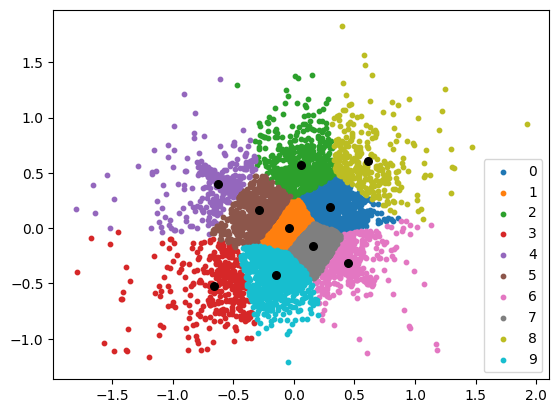

In [17]:
# Visualize our clusters
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(2)
transformed_embeddings = pca.fit_transform(trained_movie_embeddings)

label = kmeans.fit_predict(transformed_embeddings)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

for i in u_labels:
  # Plot movie clusters
  plt.scatter(transformed_embeddings[label == i , 0] , transformed_embeddings[label == i , 1] , label = i, s = 10)

# Plot centroids on top of clusters
plt.scatter(centroids[:,0] , centroids[:,1] , s = 30, color = 'black')
plt.legend()
plt.show()